<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Security-Basic-for-KISA/blob/master/Low_Frequency_PGD_Attack_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Low Frequency PGD Attack 공격 실습**

* 본 실습에서는 Inception v3 모델을 공격 대상으로 설정하여 공격합니다.
  * **Targeted attack**: 하나의 **얼룩 고양이(tabby cat)** 이미지를 **까치(magpie)로 인식하도록** 만들어 봅시다.
  * **White-box attack**: 공격자가 공격 대상 모델의 **파라미터를 모두 알고 있다고** 가정합니다.
  * **Restricted attack**: 이미지 변경이 눈에 띄지 않아야 하므로 각 픽셀은 **최대 8/255 만큼 변경**될 수 있다고 제약을 설정합니다.
* **PGD (Projected Gradient Descent)**란 본래 제약조건이 있는 상황에서의 최적화 문제에 사용되는 기법입니다.
  * 본 공격에서는 각 픽셀이 최대 8/255 이상 변경되지 않도록 하기 위해 사용됩니다.
* 코드 실행 전에 **\[런타임\]** → **\[런타임 유형 변경\]** → 유형을 **GPU**로 설정합니다.

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [3]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [4]:
# 인덱스(index) 18에 해당하는 클래스는 까치(magpie)입니다.
print(imagenet_labels[18])

magpie


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

* 공격 대상으로 설정한 Inception v3은 이미지에 대하여 **Resize**, **CenterCrop**, **ToTensor()**와 **입력 데이터 정규화**를 사용하는 모델입니다.
* 공격자는 이러한 사실을 이미 알고 있다고 가정(white-box)하며 공격용 이미지를 먼저 torch.Tensor 형태로 만듭니다.

In [5]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize(imsize), # 이미지의 크기를 변경
    transforms.CenterCrop(imsize), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [6]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [7]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [8]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
url = "http://www.image-net.org/nodes/10/02123045/ad/ad1e190b12a0c60c55816dc943f276d0edd23143.thumb"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [9]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

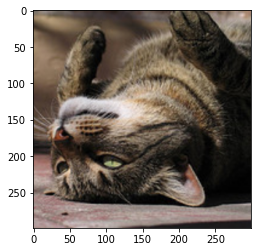

In [10]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) 모델을 불러와 사용해보기**

In [11]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 Inception v3와 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [13]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 52.198%
인덱스: 282 / 클래스명: tiger cat / 확률: 35.9409%
인덱스: 285 / 클래스명: Egyptian cat / 확률: 4.6941%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 1.3919%
인덱스: 292 / 클래스명: tiger, Panthera tigris / 확률: 0.1749%


#### **Low Frequency PGD 공격 함수 정의**

In [14]:
!pip install torch-dct

In [15]:
import torch_dct as dct

# Low Frequency PGD 공격 함수
def low_frequency_pgd_attack(model, images, labels, targeted, eps, alpha, iters):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    perturbation = torch.zeros_like(images)
    perturbation.to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
        current = torch.clamp(images + perturbation, min=0, max=1)
        outputs = model(current) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()

        # 기울기 값을 임시적으로 저장
        gradient = perturbation.grad.clone()

        # 저주파 대역만 남도록 기울기 필터링 진행
        for i in range(3):
            # 필터링 진행 (배치 크기가 1이라고 가정)
            index_of_batch = 0
            dct_processed = dct.dct_2d(gradient[index_of_batch][i])
            filtered = torch.zeros(tuple(dct_processed.shape)).to(device)
            for j in range(32):
                for k in range(32):
                    filtered[j][k] = dct_processed[j][k]
            # 저주파만 남도록 필터링된 기울기 값 저장
            gradient[index_of_batch][i] = dct.idct_2d(filtered)

        if targeted: # 타겟이 있는(targeted) 공격인 경우
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
            diff = -alpha * gradient.sign()
        else:
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = alpha * gradient.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

#### **Target Attack 예시**

In [16]:
# 공격용 파라미터 설정
targeted = True
eps = 8/255
alpha = 2/255
iters = 20

# 까치(magpie)로 분류되도록 공격 수행
label = [18]
label = torch.Tensor(label)
label = label.type(torch.long)

adv_image, perturbation = low_frequency_pgd_attack(model, image, label, targeted, eps, alpha, iters)

In [17]:
# 완성된 공격 이미지를 실제 모델에 넣어 결과 확인
outputs = model(adv_image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 34.4193%
인덱스: 17 / 클래스명: jay / 확률: 3.1816%
인덱스: 91 / 클래스명: coucal / 확률: 1.7305%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 1.3016%
인덱스: 15 / 클래스명: robin, American robin, Turdus migratorius / 확률: 0.9968%


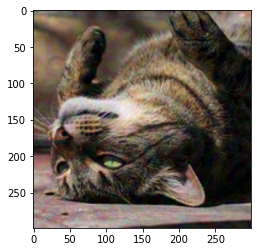

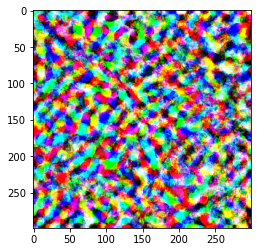

In [18]:
# 최종적으로 만들어진 공격 이미지 출력
plt.figure()
imshow(adv_image)

# 노이즈(perturbation)의 각 픽셀이 [-eps, eps] 사이의 값을 가지므로, 시각화를 위하여 [0, 1]에서 적절히 퍼진 값으로 정규화하여 출력
plt.figure()
imshow(((perturbation + eps) / 2) / eps)